In [139]:
# Parameters

#file_path = 'data/PPG2 18.04.2024 at 11:05.bin'    # good acquisition
#file_path = 'data/PPG2 18.04.2024 at 15:35.bin'    # good acquisition, but low amplitude
#file_path = 'data/PPG2 18.04.2024 at 15:35 stripped.bin'    # good acquisition, but low amplitude
#file_path = 'data/PPG2 18.04.2024 at 16:35.bin'    # much noise
#file_path = 'data/PPG2 24.04.2024 at 10:56.bin'     # good acquisition
#file_path = 'data/PPG2 24.04.2024 at 11:47.bin'     # good acquisition, higher pulse rate
#file_path = 'data/PPG2 24.04.2024 at 12:03.bin'     # stairs test 1
#file_path = 'data/PPG2 24.04.2024 at 12:06.bin'     # stairs test 2
#file_path = 'data/PPG2 24.04.2024 at 12:12.bin'     # muscle contraction
file_path = 'data/PPG3 02.05.2024 at 11:26.bin'

samples_to_strip = 15 * 30  # 15 seconds * 30 Hz
sample_amount = 15 * 30 # 20 seconds * 30 Hz

## %matplotlib notebook 

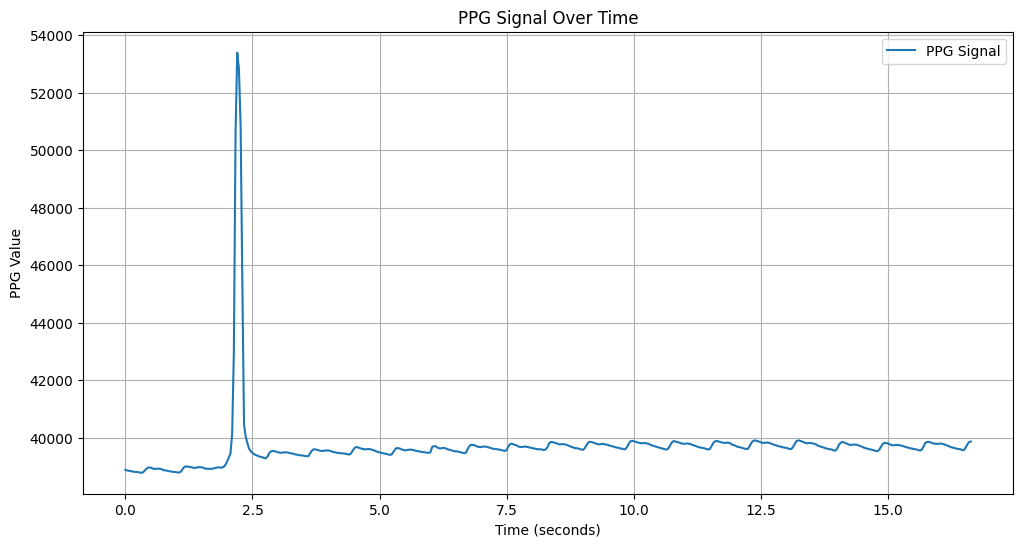

In [140]:
import numpy as np
import matplotlib.pyplot as plt

## TODO: why is the data negative?
data = -np.fromfile(file_path, dtype=np.uint16)

# Create a time axis in seconds (data sampled at 30 Hz)
time = np.arange(len(data)) / 30.0

# Plot the PPG data
plt.figure(figsize=(12, 6))
plt.plot(time, data, label='PPG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('PPG Value')
plt.title('PPG Signal Over Time')
plt.legend()
plt.grid(True)
plt.show()

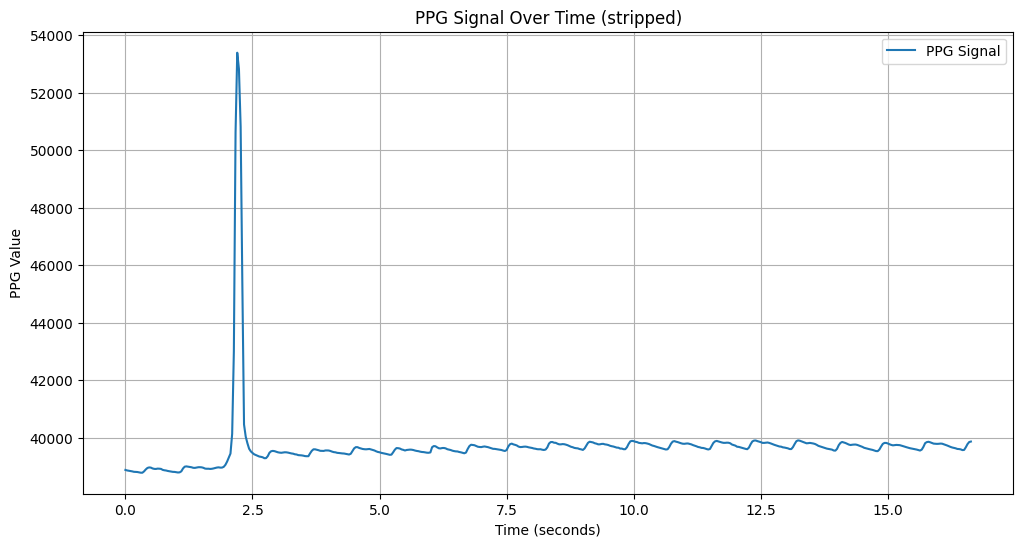

In [141]:
stripped_data = data#[samples_to_strip:samples_to_strip+sample_amount]
stripped_time = time#[samples_to_strip:samples_to_strip+sample_amount]

plt.figure(figsize=(12, 6))
plt.plot(stripped_time, stripped_data, label='PPG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('PPG Value')
plt.title('PPG Signal Over Time (stripped)')
plt.legend()
plt.grid(True)
plt.show()

In [142]:
# Normalize the PPG data (subtract mean and divide by standard deviation)

# Calculate the mean and standard deviation of the PPG data
mean_data = np.mean(stripped_data)
std_data = np.std(stripped_data)

# Normalize the PPG data
normalized_data = (stripped_data - mean_data) #/ std_data   ...... not dividing by std_data to keep amplitude for now


[ 1.         -0.58238257 -0.15838444]
[ 0.57919222  0.         -0.57919222]


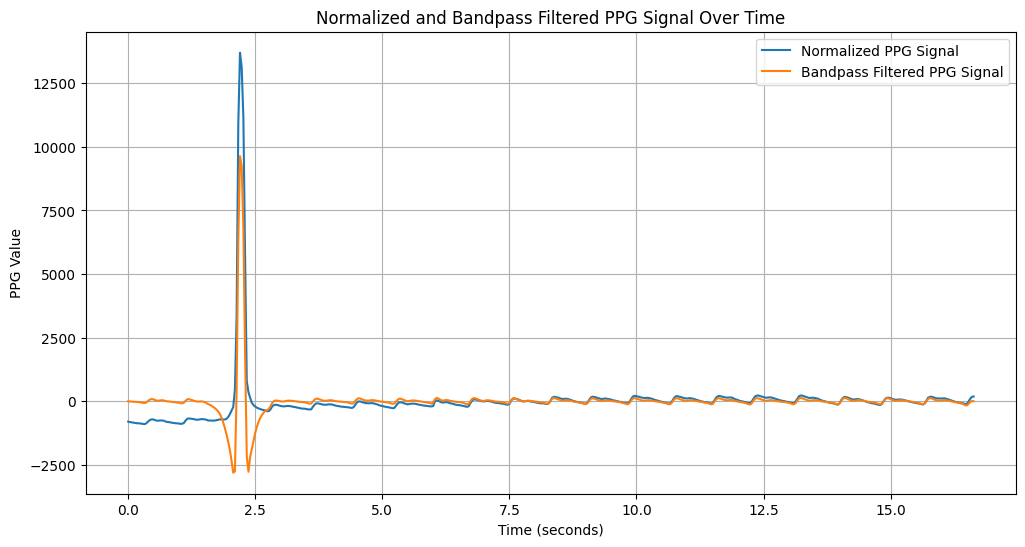

In [143]:
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    print(a)
    print(b)
    y = filtfilt(b, a, data)
    return y


lowcut = 1  
highcut = 10  
fs = 30.0  
order = 1

filtered_data = butter_bandpass_filter(normalized_data, lowcut, highcut, fs, order=order)

plt.figure(figsize=(12, 6))
plt.plot(stripped_time, normalized_data, label='Normalized PPG Signal')
plt.plot(stripped_time, filtered_data, label='Bandpass Filtered PPG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('PPG Value')
plt.title('Normalized and Bandpass Filtered PPG Signal Over Time')
plt.legend()
plt.grid(True)
plt.show()


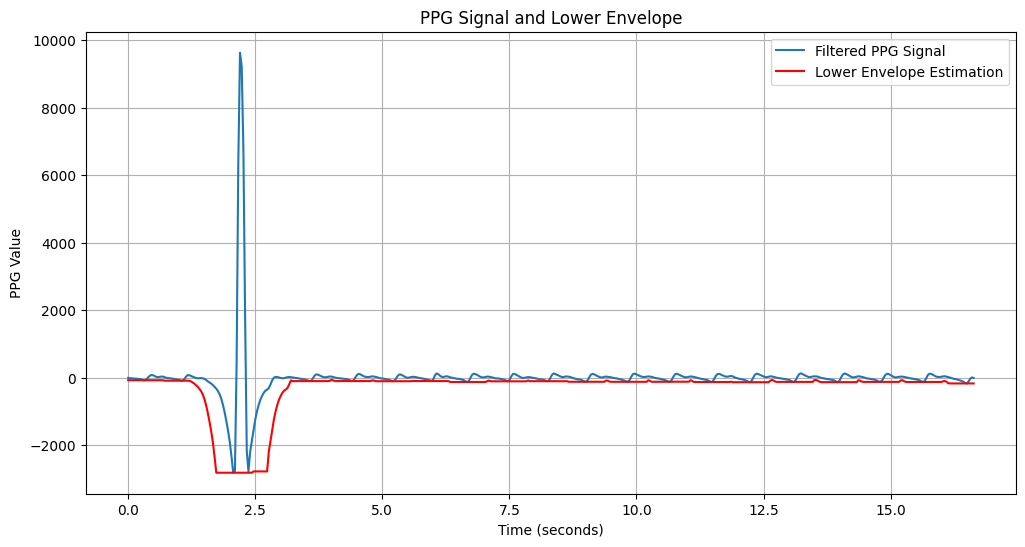

In [144]:
def minimum_filter(data, window_size):
    n = len(data)
    output = np.zeros(n)
    for i in range(n):
        start_index = max(i - window_size // 2, 0)
        end_index = min(i + window_size // 2, n)
        output[i] = np.min(data[start_index:end_index])
    return output

window_width = int(0.75 * fs)  # 0.5 seconds * 30 Hz

lower_envelope_est = minimum_filter(filtered_data, window_width)

plt.figure(figsize=(12, 6))
plt.plot(stripped_time, filtered_data, label='Filtered PPG Signal')
plt.plot(stripped_time, lower_envelope_est, label='Lower Envelope Estimation', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('PPG Value')
plt.title('PPG Signal and Lower Envelope')
plt.legend()
plt.grid(True)
plt.show()



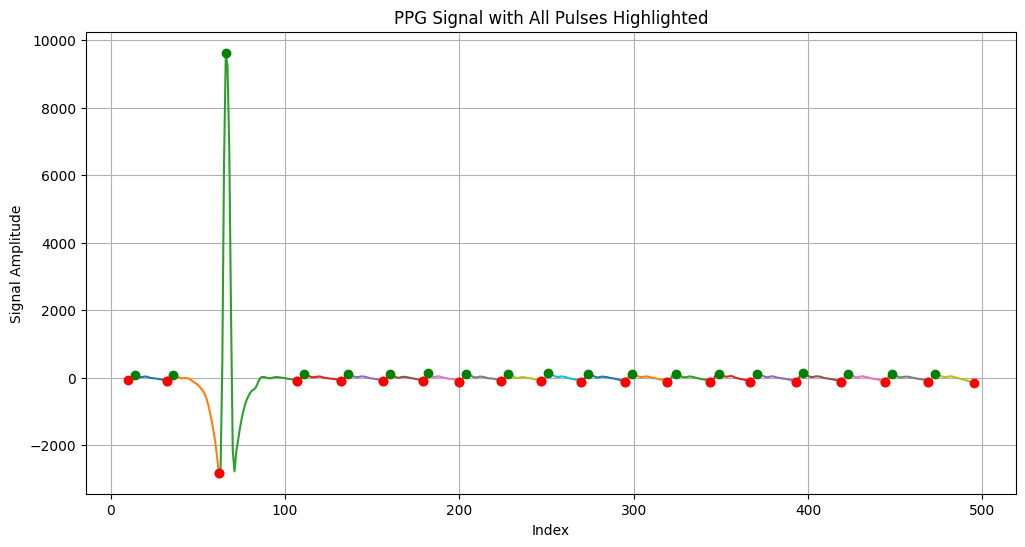

In [145]:
import numpy as np
import matplotlib.pyplot as plt

class Pulse:
    def __init__(self, signal, start_trough_index, peak_index, end_trough_index):
        self.signal = signal
        self.start_trough_index = start_trough_index
        self.peak_index = peak_index
        self.end_trough_index = end_trough_index
    
    def get_pulse_data(self):
        """Returns the slice of the signal for this pulse."""
        return self.signal[self.start_trough_index:self.end_trough_index + 1]

    def plot_pulse(self, ax):
        """Plot the pulse on the provided Axes object."""
        time_indices = range(self.start_trough_index, self.end_trough_index + 1)
        ax.plot(time_indices, self.get_pulse_data(), label=f'Pulse from {self.start_trough_index} to {self.end_trough_index}')
        ax.plot(self.peak_index, self.signal[self.peak_index], 'go')  # Mark the peak
        ax.plot([self.start_trough_index, self.end_trough_index], [self.signal[self.start_trough_index], self.signal[self.end_trough_index]], 'ro')  # Mark the troughs
        
    def amplitude(self):
        """Returns the amplitude of the pulse."""
        return self.signal[self.peak_index] - self.signal[self.start_trough_index]

    def trough_depth_difference(self):
        """Returns the depth difference between the end and start trough."""
        return self.signal[self.end_trough_index] - self.signal[self.start_trough_index]

    def relative_depth_difference(self):
        """Returns the relative depth difference between the end and start trough."""
        return self.trough_depth_difference() / self.amplitude()

    def pulse_width(self, fs):
        """Returns the pulse width based on the sampling frequency."""
        return (self.end_trough_index - self.start_trough_index) / fs


def find_troughs_from_envelope(signal, envelope):
    # Identify troughs as points where the signal matches the lower envelope
    return np.where(signal == envelope)[0]

def find_peaks(signal, trough_indices):
    # Find the maximum (peak) value between consecutive troughs
    peak_indices = []
    for i in range(len(trough_indices) - 1):
        start, end = trough_indices[i], trough_indices[i + 1]
        peak_index = np.argmax(signal[start:end+1]) + start
        peak_indices.append(peak_index)
    return peak_indices

trough_indices = find_troughs_from_envelope(filtered_data, lower_envelope_est)
peak_indices = find_peaks(filtered_data, trough_indices)

fig, ax = plt.subplots(figsize=(12, 6))

pulses = [Pulse(filtered_data, trough_indices[i], peak_indices[i], trough_indices[i + 1]) for i in range(len(peak_indices))]
for pulse in pulses:
    pulse.plot_pulse(ax)

ax.set_xlabel('Index')
ax.set_ylabel('Signal Amplitude')
ax.set_title('PPG Signal with All Pulses Highlighted')
ax.grid(True)
plt.show()


In [146]:


amplitude_values = [pulse.amplitude() for pulse in pulses]
# TODO: Determine sensible thresholds for these values, these are just placeholders
amplitude_min_threshold = 10
amplitude_max_threshold = 2000

trough_depth_values = [pulse.relative_depth_difference() for pulse in pulses]
trough_depth_difference_min_threshold = -0.25 #  -25% of the amplitude value
trough_depth_difference_max_threshold = 0.25 # 25% of the amplitude value

pulse_width_values = [pulse.pulse_width(fs) for pulse in pulses]
pulse_width_min_threshold = 1/3 # 0.333 seconds / 180 bpm
pulse_width_max_threshold = 1.5 # 1.5 seconds / 40 bpm

amplitude_values, trough_depth_values, pulse_width_values


([155.02077436859832,
  165.10911274666142,
  12448.912019530468,
  198.8228837862732,
  212.7714253078595,
  200.08704064348603,
  224.68070835475416,
  245.290041367598,
  221.55383103156538,
  227.75898863423734,
  235.61220662952599,
  241.76098987553422,
  237.1878308985041,
  239.99173902108151,
  251.78618330032947,
  253.12439362115958,
  256.33755840879496,
  239.2082106300403,
  245.10329591565846],
 [-0.09431451164785394,
  -16.517562353795434,
  0.21813199160499203,
  0.005006057075735843,
  -0.019288435185719894,
  0.025045973648761613,
  -0.12380415082065112,
  0.08162775897658137,
  0.017021475822894316,
  -0.07701187750653532,
  -0.004467309006395929,
  0.0026629149539881326,
  -0.029235099976634933,
  -0.022456826454796828,
  0.03528119887662242,
  -0.029533793516080226,
  0.031030279511398615,
  -0.009768448413080907,
  -0.177526789175338],
 [0.7333333333333333,
  1.0,
  1.5,
  0.8333333333333334,
  0.8,
  0.7666666666666667,
  0.7,
  0.8,
  0.7666666666666667,
  0.76

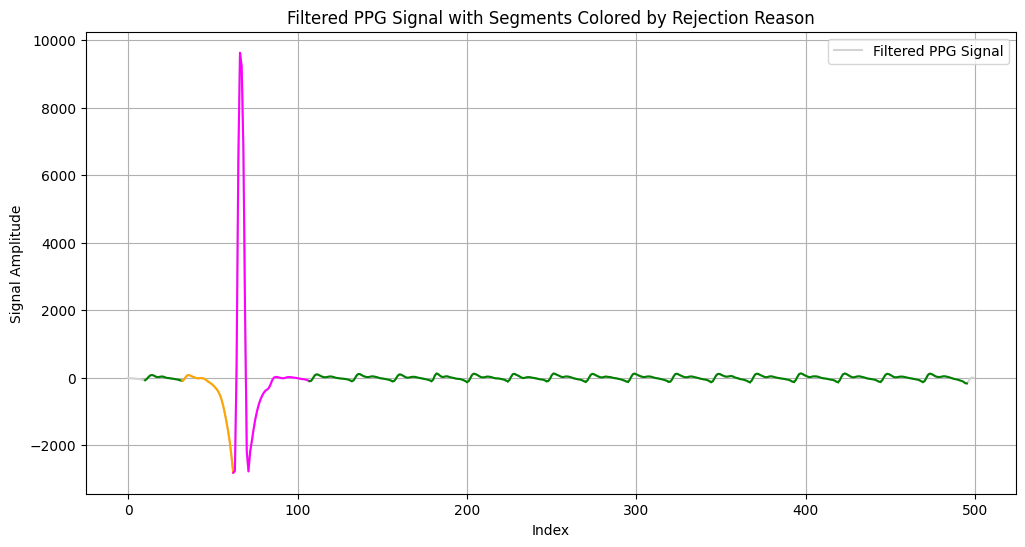

In [147]:
# Calculate the validity for each characteristic
amplitude_valid = [(amplitude_min_threshold <= value <= amplitude_max_threshold) for value in amplitude_values]
trough_depth_valid = [(trough_depth_difference_min_threshold <= value <= trough_depth_difference_max_threshold) for value in trough_depth_values]
pulse_width_valid = [(pulse_width_min_threshold <= value <= pulse_width_max_threshold) for value in pulse_width_values]

valid_indices = []
plt.figure(figsize=(12, 6))
plt.plot(filtered_data, label='Filtered PPG Signal', color='lightgray')

for i, pulse in enumerate(pulses):
    start, end = pulse.start_trough_index, pulse.end_trough_index
    pulse.valid = True  # Assume segment is valid unless a check fails

    # Check each condition
    if not pulse_width_valid[i]: # begin with pulse width, it's the strongest indicator
        segment_color = 'red'  # Pulse width invalid
        pulse.valid = False
    elif not amplitude_valid[i]:
        segment_color = 'magenta'  # Amplitude invalid
        pulse.valid = False
    elif not trough_depth_valid[i]:
        segment_color = 'orange'  # Trough depth invalid
        pulse.valid = False
    else:
        segment_color = 'green'  # Valid segment

    if pulse.valid:
        valid_indices.append(i)

    # Plot the pulse segment with the determined color
    plt.plot(range(start, end + 1), filtered_data[start:end + 1], color=segment_color)

plt.xlabel('Index')
plt.ylabel('Signal Amplitude')
plt.title('Filtered PPG Signal with Segments Colored by Rejection Reason')
plt.grid(True)
plt.legend()
plt.show()

[None, None, None, None, None, 73.46938775510206, 78.26086956521739, 81.81818181818181, 78.26086956521739, 76.59574468085103, 78.26086956521739, 75.00000000000001, 71.99999999999994, 72.00000000000003, 76.59574468085107, 75.00000000000001, 69.23076923076927, 70.58823529411761, 71.99999999999994]


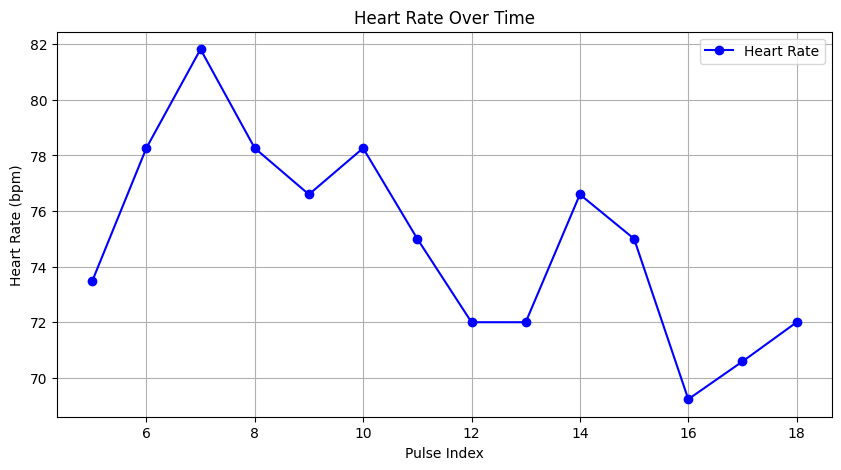

In [148]:
def calculate_heart_rate(pulses, fs):
    """
    Calculate the heart rate based on valid peak indices using a sliding window method.
    This function ensures that all peaks in a window are valid and consecutive in terms of their original sequence.

    :param pulses: List of Pulse objects which contain peak indices.
    :param valid_indices: List of indices that are considered valid.
    :param fs: Sampling frequency.
    :returns: List of estimated heart rates for valid indices; None for other indices.
    """
    heart_rates = [None] * len(pulses)  # Initialize heart rate list with None for all pulses.
    window_size = 3  # Window size of 5 peaks.

    # Iterate through valid_peak_indices while ensuring enough consecutive valid peaks for the window.
    for i in range(window_size - 1, len(pulses)):
        # check if the current window contains consecutive valid indices.
        if not all(pulses[i - offset].valid for offset in range(window_size)):
            continue
            
        # Calculate the heart rate based on the peak indices in the window.
        window_peaks = [pulses[i - offset].peak_index for offset in range(window_size)]
        window_times = [peak_index / fs for peak_index in window_peaks]
        heart_rates[i] = 60 / -np.diff(window_times).mean()        
    
    return heart_rates

    

# Example usage:
# Assuming `fs` is defined as the sampling frequency.
heart_rates = calculate_heart_rate(pulses, fs)
print(heart_rates)

# Prepare the plot
plt.figure(figsize=(10, 5))
plt.plot(heart_rates, label='Heart Rate', color='blue', marker='o')  # Use markers to highlight each data point
plt.title('Heart Rate Over Time')
plt.xlabel('Pulse Index')
plt.ylabel('Heart Rate (bpm)')
plt.grid(True)
plt.legend()
plt.show()

/var/folders/yb/3195fdfn2vb_j67t_92p2yzw0000gn/T/ipykernel_13262/2702423267.py:25: RuntimeWarning: Mean of empty slice
  mean_pulse = np.nanmean(np.vstack(aligned_pulses), axis=0)


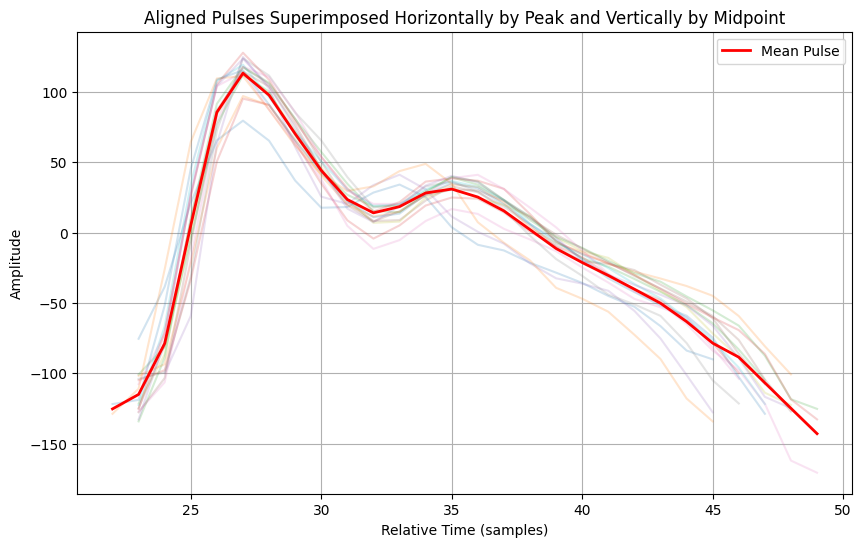

In [149]:
def align_pulses_horizontally(pulses):
    max_pulse_width = 0
    aligned_pulses = []

    # Calculate necessary alignments and vertical offsets
    for pulse in pulses:
        pulse_data = pulse.get_pulse_data()
        pulse_length = len(pulse_data)
        max_pulse_width = max(max_pulse_width, pulse_length)
    
    # Align all pulses horizontally and vertically
    for pulse in pulses:
        pulse_data = pulse.get_pulse_data()
        peak_position_in_pulse = pulse.peak_index - pulse.start_trough_index
        padding_before = max(max_pulse_width - peak_position_in_pulse, 0)
        offset_after = max(2 * max_pulse_width - (padding_before + len(pulse_data)), 0)
        aligned_pulse = np.pad(pulse_data, (padding_before, offset_after), 'constant', constant_values=(np.nan, np.nan))

        aligned_pulses.append(aligned_pulse)
    
    return aligned_pulses

valid_pulses = [pulses[i] for i in valid_indices]
aligned_pulses = align_pulses_horizontally(valid_pulses)
mean_pulse = np.nanmean(np.vstack(aligned_pulses), axis=0)


plt.figure(figsize=(10, 6))
for pulse in aligned_pulses:
    plt.plot(pulse, alpha=0.2) 

plt.plot(mean_pulse, color='red', linewidth=2, label='Mean Pulse')
plt.title('Aligned Pulses Superimposed Horizontally by Peak and Vertically by Midpoint')
plt.xlabel('Relative Time (samples)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

[1.1086601529883156, 1.1661908635183347, 1.0423390700472273, 1.05306060365165, 0.7834121492043085, 0.9622254625520825, 0.9867321869417468, 0.8446234406489347, 0.9956813512305934, 0.9321026487247763, 0.9419232585524137, 0.7740678702039263, 0.9976227848805416, 0.9795871310754105, 0.934769333370799, 1.0027011267793933, 0.8575833047942799]


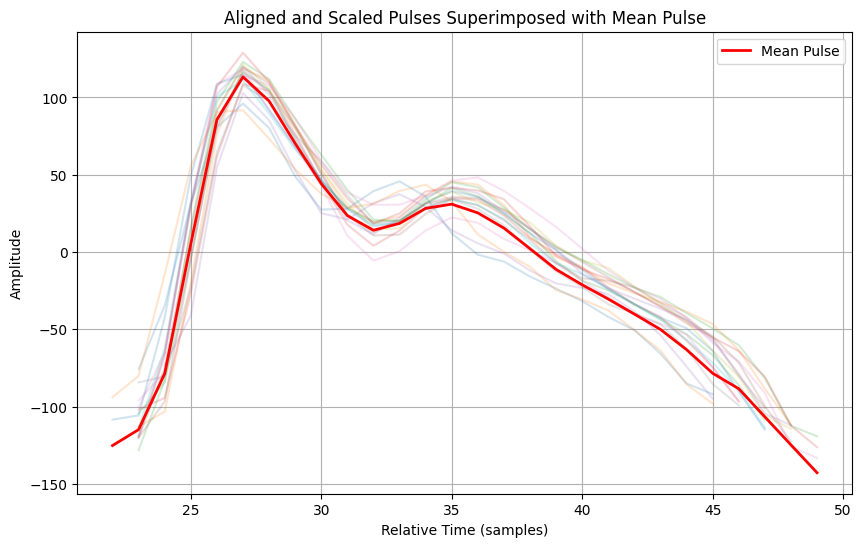

In [150]:
def scale_pulses_to_minimize_difference(pulses, mean_pulse):
    scaled_pulses = []
    scaling_factors = []

    for pulse in pulses:
        # Only consider non-NaN values for calculation
        valid_indices = ~np.isnan(pulse)
        valid_pulse = pulse[valid_indices]
        valid_mean_pulse = mean_pulse[valid_indices]

        std_valid_pulse = valid_pulse - np.mean(valid_pulse)
        std_valid_mean_pulse = valid_mean_pulse - np.mean(valid_mean_pulse)

        # Calculate the optimal scaling factor using the dot product
        scale_factor = np.dot(std_valid_pulse, std_valid_mean_pulse) / np.dot(std_valid_pulse, std_valid_pulse)

        std_pulse = pulse - np.mean(valid_pulse)  
        scaled_pulses.append(std_pulse * scale_factor)
        scaling_factors.append(scale_factor)

    return scaled_pulses, scaling_factors

scaled_pulses, scaling_factors = scale_pulses_to_minimize_difference(aligned_pulses, mean_pulse)

print(scaling_factors)

plt.figure(figsize=(10, 6))
for pulse, factor in zip(scaled_pulses, scaling_factors):
    plt.plot(pulse, alpha=0.2)

plt.plot(mean_pulse, color='red', linewidth=2, label='Mean Pulse')
plt.title('Aligned and Scaled Pulses Superimposed with Mean Pulse')
plt.xlabel('Relative Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

47.71364924759001
[18.843752863672794, 13.586643981894248, 6.134029349428767, 8.851470202893305, 13.48470273497123, 8.3104106774054, 8.910947145064481, 6.847067584845033, 9.246305361952652, 6.147021973273005, 10.437242902335681, 18.835569195442705, 15.253881862869914, 14.259614220434878, 9.782010778569834, 9.501663344164225, 15.022911366665362]


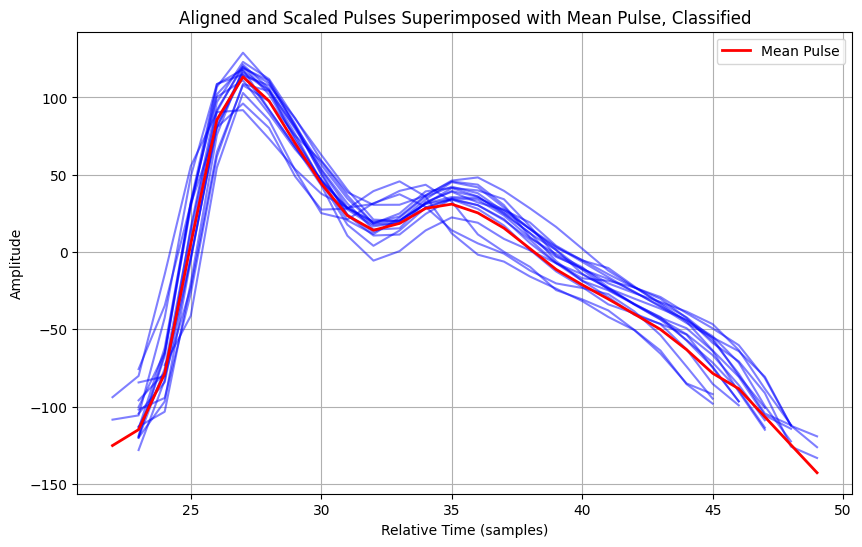

In [151]:
def classify_pulses(pulses, mean_pulse, threshold):
    classifications = []
    differences = []

    for pulse in pulses:
        # Calculate absolute difference from the mean pulse, ignoring NaNs
        valid_indices = ~np.isnan(pulse)
        difference = np.abs(pulse[valid_indices] - mean_pulse[valid_indices])
        mean_difference = np.mean(difference)

        if mean_difference <= threshold:
            classifications.append("Good")
        else:
            classifications.append("Bad")
        
        differences.append(mean_difference)

    return classifications, differences


non_nan_mean_pulse = mean_pulse[~np.isnan(mean_pulse)]
mean_amplitude = non_nan_mean_pulse[np.argmax(non_nan_mean_pulse)] - non_nan_mean_pulse[0]

difference_threshold = 0.2 * mean_amplitude # TODO: Is this a good threshold?

classifications, mean_differences = classify_pulses(scaled_pulses, mean_pulse, difference_threshold)

print(difference_threshold)
print(mean_differences)

plt.figure(figsize=(10, 6))
colors = {'Good': 'blue', 'Bad': 'orange'}
alpha_values = {'Good': 0.5, 'Bad': 0.2}
for pulse, classification in zip(scaled_pulses, classifications):
    plt.plot(pulse, alpha=alpha_values[classification], color=colors[classification])

plt.plot(mean_pulse, color='red', linewidth=2, label='Mean Pulse')
plt.title('Aligned and Scaled Pulses Superimposed with Mean Pulse, Classified')
plt.xlabel('Relative Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()